In [1]:
import h3
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import folium

path = '/Users/patrickmaus/Documents/projects/cabs/'

def plot_scatter(df, metric_col, x='lon', y='lat', marker='.', alpha=1, colormap='viridis'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha);
    plt.xticks([], []); plt.yticks([], [])

def plot_fol(df):
    m = folium.Map(location=[df.lat.median(), df.lon.median()],
                   zoom_start=4, tiles='OpenStreetMap')
    points = list(zip(df.lat, df.lon))
    folium.Marker(points).add_to(m)
    return m

In [2]:
# read in cabs data
df_full = pd.read_csv(path+'cabs_10.csv')
#%% remove the one outlier thats an error
df_full.drop(30248, axis=0, inplace=True)
# convert to gdf 
gdf = gpd.GeoDataFrame(df_full, geometry=gpd.points_from_xy(df_full.lon, df_full.lat), crs='EPSG:4326')


In [3]:
# plot each one
cabs = gdf.cab_name.unique()

    


In [4]:
#%% sort by time and name, get prev/next fare
gdf = gdf.sort_values(['cab_name', 'time']).reset_index(drop=True)
gdf['fare_next'] = gdf['fare'].shift(-1)
gdf['fare_prev'] = gdf['fare'].shift(1)

#%% determine pickups and dropoffs
pickups = gdf[(gdf['fare']==1) & (gdf['fare_prev']==0)]
dropoffs = gdf[(gdf['fare']==1) & (gdf['fare_next']==0)]

pickups = pickups.drop(['fare', 'fare_prev', 'fare_next'], axis=1)
dropoffs = dropoffs.drop(['fare', 'fare_prev', 'fare_next'], axis=1)
#%%

def convert_hex(df, hex_size):
    hex_size = 8
    hex_col = 'hex'+str(hex_size)
    
    # find hexs containing the points
    df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat,x.lon,hex_size),1)
    
    # aggregate the points
    dfg = df.groupby(hex_col).size().to_frame('cnt').reset_index()
    
    #find center of hex for visualization
    dfg['lat'] = dfg[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfg['lon'] = dfg[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfg

hex_pickups = convert_hex(pickups, 8)
hex_dropoffs = convert_hex(dropoffs, 8)
hex_full = convert_hex(df_full, 8)

In [42]:
from folium import plugins
from folium.plugins import HeatMap

heat_df = hex_full.loc[:,['lat','lon','cnt']]
heat_data = heat_df.values.tolist()

m = folium.Map(location=[heat_df.lat.median(), heat_df.lon.median()],zoom_start=10)
HeatMap(heat_data, radius=25).add_to(m)
m


In [51]:
import skmob
tdf = skmob.TrajDataFrame(df_full.rename({'lon':'lng', 'time':'datetime','cab_name':'uid'}, axis=1))
tdf.head()

,lat,lng,fare,datetime,uid,geometry
0,37.61549,-122.38821,0,2008-06-09 18:43:48,adkavy,POINT (-122.38821 37.61549)
1,37.61562,-122.38849,0,2008-06-09 18:42:48,adkavy,POINT (-122.38849 37.61562)
2,37.61518,-122.39029,0,2008-06-09 18:41:43,adkavy,POINT (-122.39029 37.61518)
3,37.61393,-122.39508,0,2008-06-09 18:40:43,adkavy,POINT (-122.39508 37.61393)
4,37.60493,-122.38362,0,2008-06-09 18:39:43,adkavy,POINT (-122.38362 37.60493)


In [54]:
tdf.plot_trajectory(max_users=1)

/Users/patrickmaus/anaconda3/envs/spatial_39/lib/python3.9/site-packages/skmob/core/trajectorydataframe.py:569: UserWarning: If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.
  return plot.plot_trajectory(self, map_f=map_f, max_users=max_users, max_points=max_points, style_function=style_function,


In [5]:
from skmob.preprocessing import detection
stdf = detection.stay_locations(tdf, stop_radius_factor=0.5, minutes_for_a_stop=20.0, 
                                spatial_radius_km=0.2, leaving_time=True)
print('Points of the original trajectory:\t%s'%len(tdf))
print('Points of stops:\t\t\t%s'%len(stdf))

NameError: name 'tdf' is not defined

In [61]:
print(stdf[stdf['uid']=='ackgrica'])

          lat         lng  fare            datetime       uid  \
0   37.755470 -122.392270     0 2008-05-17 10:57:40  ackgrica   
1   37.668510 -122.394190     0 2008-05-18 08:17:11  ackgrica   
2   37.616485 -122.386225     1 2008-05-18 17:46:51  ackgrica   
3   37.638960 -122.422500     0 2008-05-18 23:36:51  ackgrica   
4   37.653090 -122.426100     0 2008-05-19 00:00:42  ackgrica   
..        ...         ...   ...                 ...       ...   
87  37.621940 -122.400750     0 2008-06-09 05:08:52  ackgrica   
88  37.694110 -122.391880     0 2008-06-09 06:07:42  ackgrica   
89  37.513470 -122.255510     0 2008-06-09 08:48:52  ackgrica   
90  37.617730 -122.386780     0 2008-06-09 16:03:33  ackgrica   
91  37.396930 -122.018690     1 2008-06-09 17:21:48  ackgrica   

                                geometry    leaving_datetime  
0            POINT (-122.39227 37.75547) 2008-05-17 17:28:59  
1            POINT (-122.39419 37.66851) 2008-05-18 17:29:39  
2            POINT (-122.38679

In [56]:
m = stdf.plot_trajectory(max_users=1, start_end_markers=False)
stdf.plot_stops(max_users=1, map_f=m)

/Users/patrickmaus/anaconda3/envs/spatial_39/lib/python3.9/site-packages/skmob/core/trajectorydataframe.py:569: UserWarning: If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.
  return plot.plot_trajectory(self, map_f=map_f, max_users=max_users, max_points=max_points, style_function=style_function,


<AxesSubplot:xlabel='lon', ylabel='lat'>

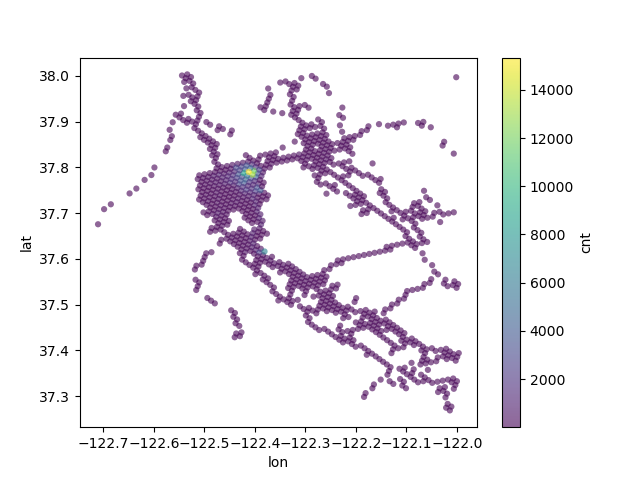

In [30]:
hex_full.plot.scatter(x='lon', y='lat', c='cnt', edgecolors='none', colormap='viridis', marker='o', alpha=.6)


In [11]:
hex_pickups.head()


,hex8,cnt,lat,lon
0,88283080c9fffff,82,37.800614,-122.398793
1,88283080cbfffff,104,37.806453,-122.406164
2,88283080d9fffff,19,37.809896,-122.423934
3,88283080ddfffff,23,37.812292,-122.413536
4,8828308101fffff,1,37.806968,-122.272629


In [17]:
df = hex_dropoffs
m = folium.Map(location=[df.lat.median(), df.lon.median()],
                zoom_start=8, tiles='OpenStreetMap')
points = list(zip(df.lat, df.lon))
for point in points:
    folium.Marker(point).add_to(m)
m
